Uvozimo pakete in pomožne datoteke

In [1]:
import main
import pandas as pd
from spremenljivke import *
%matplotlib inline
pd.set_option("display.max_rows", 50)

Pridobimo željene podatke. Najprej funkcija `main.main()` pridobi podatke iz interneta in jih pospravi v datoteko, shranjeni v mapi `slovar` v csv datoteki `besede.csv`. Pot do te datoteke je shranjena v spremenljivki `pot_slovar_csv` iz datoteke `spremenljivke.py`. 
Pod spremenljivko `raz` shranimo razpredelnico pridobljenih podatkov slovarja.

In [2]:
# main.main(od=1, do=1)
razpredelnica = pd.read_csv(pot_slovar_csv)
razpredelnica.count()

ime      93635
vrsta    93635
dtype: int64

Poglejmo si koliko je posamezne besedne vrste.
V drugi vrstici preimenujem ime stolpca iz `"ime"` v `"število"`, ker ko preštejemo koliko je besed v stolpcu `"ime"`, program poimenuje stolpec, kamor zapiše število posamezne besedne vrste, `"ime"`.
Na koncu pa še uredimo besedne vrste po količini.

In [4]:
število_vrste = razpredelnica.groupby("vrsta")[["ime"]].count()
število_vrste.rename(columns={"ime":"število"}, inplace=True)
število_vrste.sort_values("število", inplace=True, ascending=False)
število_vrste.head(20)

,število
vrsta,
samostalnik moškega spola,23226
samostalnik ženskega spola,22579
pridevnik,21468
dovršni glagol,8686
samostalnik srednjega spola,8465
nedovršni glagol,6666
prislov,1164
dovršni in nedovršni glagol,746
členek,183


To si lahko pogledamo na grafu

<Axes: xlabel='vrsta'>

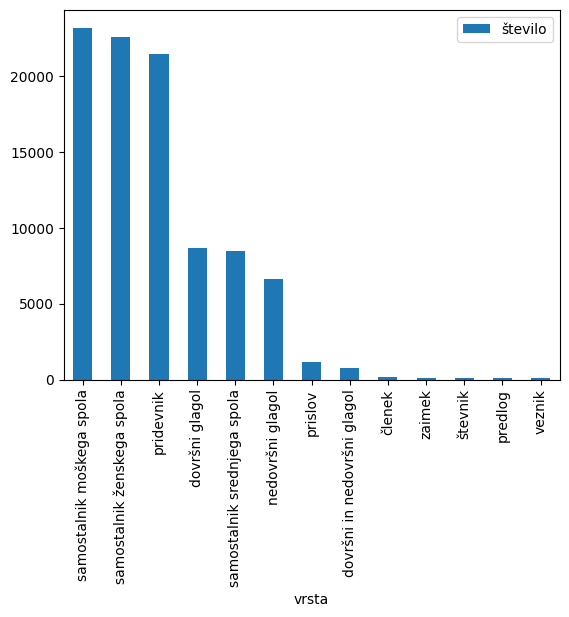

In [6]:
število_vrste.plot.bar()

Kot lahko vidite, to niso le besedna vrste ampak tudi dodatni podatki kot so spol in dovršnost. Zaradi teh dodatnih podatkov težje vidimo koliko je besed posamezne besedne vrste. Popravimo to. Prve štiri vrstice kode vsaki besedi iz originalne razpredelnice priredijo prav besedno vrsto.

Funkcija `štetje_stolpca` prešteje kolikokrat se vsaka različna vrednost v stolpcu ponovi.

In [7]:
raz_vrste = razpredelnica.copy()
for vrsta in besedne_vrste:
    raz_vrste.loc[raz_vrste["vrsta"].apply(lambda x: type(x) != float and vrsta in x), "besedna vrsta"] = vrsta
raz_vrste.loc[raz_vrste["vrsta"].apply(lambda x: type(x) == float), "besedna vrsta"] = "neznano"

def štetje_stolpca(raz, stolpec):
    raz = raz.groupby(stolpec)[[stolpec]].count()
    raz.rename(columns={stolpec:"število"}, inplace=True)
    raz.sort_values("število", inplace=True, ascending=False)
    return raz
# raz_vrste[["ime", "vrsta", "besedna vrsta"]].loc[raz_vrste["besedna vrsta"].isna()]
štetje_stolpca(raz_vrste, "besedna vrsta")

,število
besedna vrsta,
samostalnik,54270
pridevnik,21468
glagol,16098
prislov,1164
členek,183
zaimek,131
števnik,126
veznik,76


Veliko bolje. Zdaj bo tudi graf natančnejši.

<Axes: xlabel='besedna vrsta'>

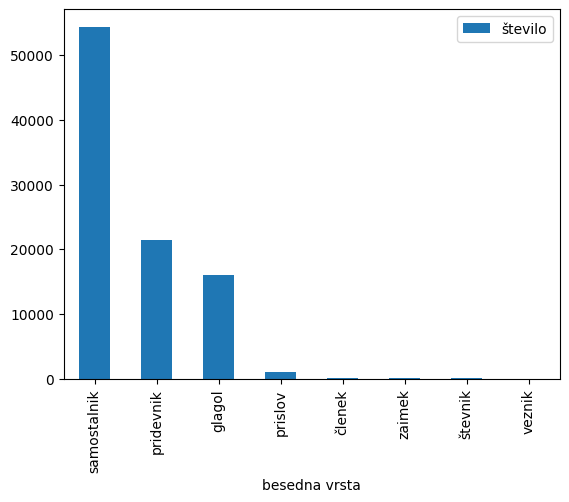

In [8]:
štetje_stolpca(raz_vrste, "besedna vrsta").plot.bar()

Sedaj ko smo uspeli ločiti besede na posamezne besedne vrste, lahko iščemo povprečno besedo besedne vrste.
Povprečna beseda je tisti niz črk, za katerega velja, da je njegova dolžina toliko kolikor je povprečje dolžin besed (zaokroženo seveda na celo število) in njegova i-ta črka je tista, ki se največkrat pojavi na i-tem mestu besed. 

Funkcija `razpredelnica_vrste` vrne podtabelo željene besedne vrste. Na primer za samostalnike.

In [9]:
def razpredelnica_vrste(vrsta="", raz = razpredelnica):
    seznam = raz["vrsta"].apply(lambda x: type(x) != float and vrsta in x)
    return raz.loc[seznam]

razpredelnica_samostalnikov = razpredelnica_vrste("samostalnik")
razpredelnica_samostalnikov

,ime,vrsta
0,á,samostalnik moškega spola
5,á,samostalnik moškega spola
6,abalienácija,samostalnik ženskega spola
8,abbé,samostalnik moškega spola
9,abc,samostalnik moškega spola
...,...,...
93626,žvrgolênje,samostalnik srednjega spola
93629,žvrgolévček,samostalnik moškega spola
93631,žvŕkelj,samostalnik moškega spola
93632,žvŕklja,samostalnik ženskega spola


Funkcija `povprečna_beseda` vrne povprečno besedo neke razpredelnice. Torej najprej najde povprečno dolžino besed, nato pa s pomočjo pomožne funkcije `črka_besede`, ki vrne črko na poljubnem mestu besede, poišče katera črka je najpogostejša na posameznem mestu.

In [22]:

def črka_besede(i, beseda):
    if len(beseda)<=i:
        return 
    return beseda[i]

from collections import Counter
def povprečna_beseda(raz):
    try:
        dolžina = round(raz["ime"].apply(len).sum()/raz["ime"].count())
    except ValueError:
        return "Oprosti, te besedne vrste ni v razpredelnici"
    odg = ""
    for i in range(dolžina):
        seznam = raz["ime"].apply(lambda beseda: črka_besede(i, beseda))
        crke = Counter(seznam).most_common() 
        if crke[0][0] == None: #Če je večina besed krajših od i
            odg += crke[1][0]
        else:
            odg += crke[0][0]
    return odg

povprečna_beseda(razpredelnica_vrste("samostalnik"))

'prronnnna'

Še ena zanimiva stvar za analizirati bi bila pogostost posamezne črke.

Funkcija `štetje_črk` prešteje kolikokrat se ponovi posamezna črka v poljubni razpredelnici.

In [11]:
def štetje_črk(raz, bes):
    if bes == True:
        st = 0
        for ime in raz["ime"]:
            st += len(ime)
        return st
    if bes == False:
        st = 0
        for ime in raz["ime"]:
            st += sum([not c.isalpha() for c  in ime])
        return st
    
    bes = bes.replace("a", "aáà").replace("e", "eéèê").replace("o", "oóòô").replace("i", "iíì")
       
    st = 0
    for c in bes:
        for ime in raz["ime"]:
            st += ime.count(c)
    return st
štetje_črk(razpredelnica, "t")

59315

Funkcija `razpredelnica_črk` sprejme razpredelnico ali seznam razpredelnic, ter opcijsko oznake za stolpce, in vrne tabelo, ki pove kolikokrat se v posamezni razpredelnici besed ponovi posamezna črka, ter kolikšen delež vseh črk predstavlja ta črka izražen v procentih. S tem lahko primerjamo pogostost črk med različnimi besenimi vrstami.

In [12]:
def razpredelnica_črk(sez_raz, oznake=None):
    if oznake != None:
        prave_oznake = ["črka"]
        for oznaka in oznake:
            prave_oznake.append(oznaka)
            prave_oznake.append(oznaka+" %")
    else:
        prave_oznake = None
    
    if type(sez_raz) != list:
        sez_raz = [sez_raz]
    seznam = [list(abeceda)]
    for raz in sez_raz:
        štetje = []
        procent = []
        skupaj = sum([len(c) for c in raz["ime"]])
        for c in abeceda:
            st = štetje_črk(raz, c)
            štetje.append(st)
            try:
                procent.append(round(st/skupaj*100, 3))
            except ZeroDivisionError:
                procent.append(None)
        seznam.append(štetje)
        seznam.append(procent)
    return pd.DataFrame(seznam, index=prave_oznake).transpose()

razpredelnica_črk([razpredelnica_samostalnikov, razpredelnica], ["saomostalniki", "vse"])

,črka,saomostalniki,saomostalniki %,vse,vse %
0,a,54083,11.636,87679,10.613
1,b,7680,1.652,12955,1.568
2,c,10697,2.301,12871,1.558
3,č,7701,1.657,13675,1.655
4,d,11564,2.488,20556,2.488
5,e,43578,9.376,77594,9.392
6,f,2538,0.546,3843,0.465
7,g,6848,1.473,11138,1.348
8,h,3038,0.654,5381,0.651
9,i,37348,8.035,84460,10.223


Poglejmo si primerjavo števila črk med različnimi besednimi vrstami na grafu. 

Glede na podatke bi bilo primernejše uporabiti stolpični diagram za prikaz, vendar sem se odličila, da so podatki lažje razvidni iz črtnega diagrama.

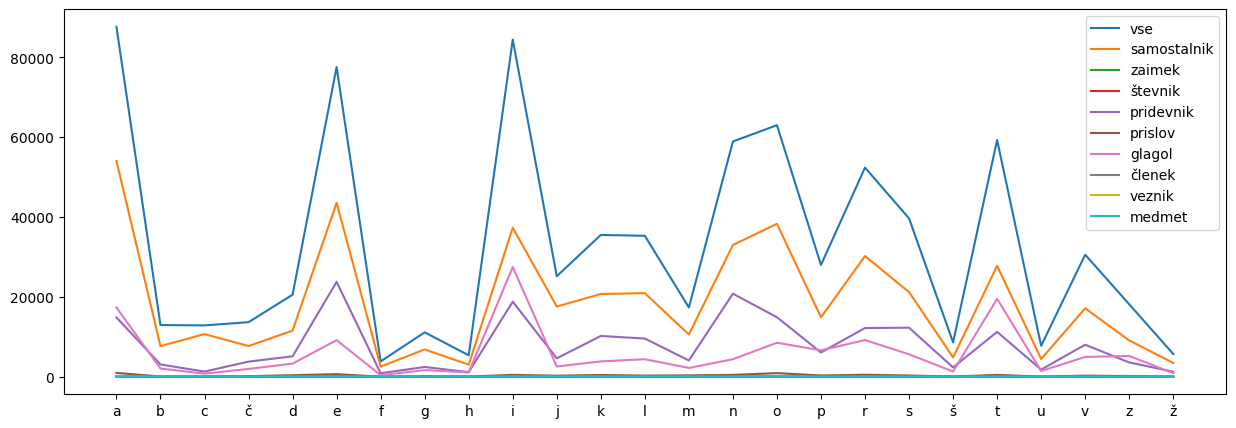

In [28]:
graf = razpredelnica_črk([razpredelnica]+[razpredelnica_vrste(vrsta) for vrsta in besedne_vrste], oznake=["vse"]+besedne_vrste)[["vse"]+besedne_vrste].plot.line(figsize=(15, 5))
graf.set_xticks(range(len(abeceda)));
graf.set_xticklabels(list(abeceda));

Najbrž nam bo graf pogostosti črk povedal več.

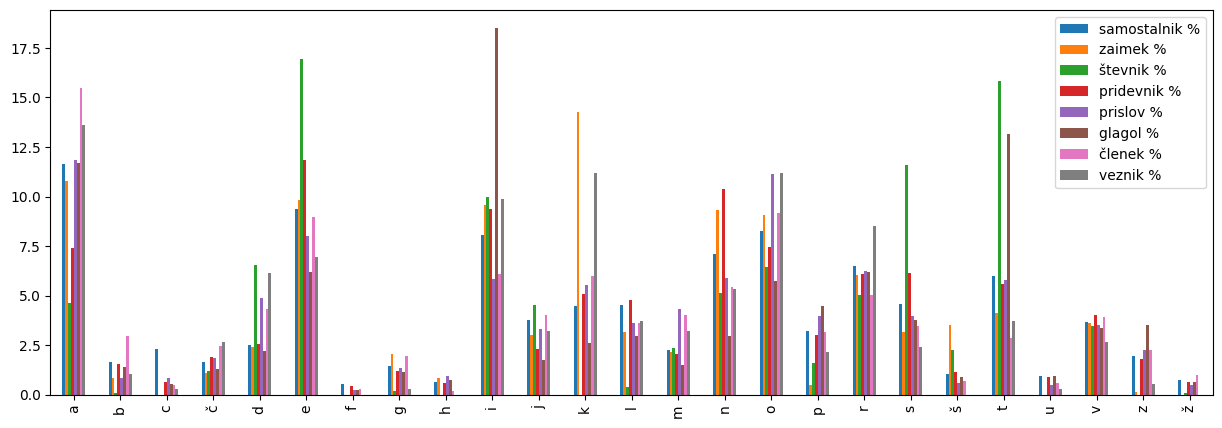

In [33]:
graf = razpredelnica_črk([razpredelnica_vrste(vrsta) for vrsta in besedne_vrste], oznake=besedne_vrste)[map(lambda x: x+" %", besedne_vrste)].plot.bar(figsize=(15, 5))
graf.set_xticks(range(len(abeceda)));
graf.set_xticklabels(list(abeceda));